<a href="https://colab.research.google.com/github/moustafa-7/H.264-implementation/blob/master/motion_estimation_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Function to extract frames 
def FrameCapture_2(path): 
      
    # Path to video file 
    vidObj = cv2.VideoCapture(path)
  
    # Used as counter variable 

    frames = []
    for i in range(5):
      success, image = vidObj.read() 
      frames.append(image)
    

    return frames

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import math


def get_motion_and_residual(frames, reference_seperation):

  block_size_1 = 16
  block_size_2 = 16

  rows, cols = frames[0].shape

  rows = rows//block_size_1
  cols = cols//block_size_2


  motion_vectors = []
  residuals = []
  

####################################################################################
  motion = []
  predicted = []
  

  for i in range(len(frames)):

    if(i%reference_seperation == 0):
      reference_frame = frames[i]
      motion.append([[0,0]]*rows*cols)
      print("00")
      residuals.append(np.zeros(frames[i].shape))
      plt.imshow(residuals[-1])
      predicted.append(frames[i])
      continue
    
    predicted_image = np.zeros((rows* block_size_1, cols * block_size_2))
    for row in range(rows):  # 720 * 1280                # 35 (rows) * 40 (cols) 
      for col in range(cols):
        
        search_range_x = range(row*block_size_1 - block_size_1, (row+1)*block_size_1 + block_size_1)
        search_range_y = range(col*block_size_2 - block_size_2, (col +1)*block_size_2 + block_size_2)

        if (row*block_size_1 - block_size_1 < 0):
          search_range_x = range(0, (row+1)*block_size_1 + block_size_1 )
        
        elif(row*block_size_1 + block_size_1 + block_size_1 - 1 >= (rows - 1) * block_size_1):
          search_range_x = range(row*block_size_1 - block_size_1 , (rows - 1)*block_size_1  -1 )



        if (col*block_size_2 - block_size_2 < 0):
          search_range_y = range(0, (col+1)*block_size_2 + block_size_2)
        
        elif(col*block_size_2 + block_size_2 + block_size_2 - 1 >= (cols -1) * block_size_2):
          search_range_y = range(col*block_size_2 - block_size_2 , (cols -1)  * block_size_2  - 1)

        min_diff = math.inf


        # define the search region of that block 

        for shift_x in search_range_x:
          for shift_y in search_range_y:
            block_temp = frames[i][shift_x:shift_x+block_size_1, shift_y:shift_y+block_size_2]
            block = reference_frame[row* block_size_1:(row+1) * block_size_1, col*block_size_2:(col+1)*block_size_2]

            diff = np.sum(np.square(block_temp - block))

            if(diff < min_diff):
              min_diff = diff
              x_min = shift_x - row*block_size_1
              y_min = shift_y - col*block_size_2
        
        motion_vectors.append([x_min, y_min])
    
    motion.append(motion_vectors)
    counter = 0
    for r in range(rows):
        for c in range(cols):
        
          predicted_image[r*block_size_1+ motion[-1][counter][0]:(r+1)*block_size_1+ motion[-1][counter][0],
                          c*block_size_2+ motion[-1][counter][1]:(c+1)*block_size_2+motion[-1][counter][1]
                          ] += reference_frame[r* block_size_1:(r+1) * block_size_1, c*block_size_2:(c+1)*block_size_2]
          counter = counter + 1
    
    predicted.append(predicted_image)
          

    residual = frames[i][:rows* block_size_1, :cols * block_size_2] - predicted_image      
    residuals.append(residual)      

  return motion, residuals, predicted


In [0]:
def chroma_residual(motion, chroma, reference_chroma):
  block_size_1 = 16//4
  block_size_2 = 16//2
  rows, cols = chroma.shape
  rows = rows//block_size_1
  cols = cols//block_size_2

  predicted_chroma = np.zeros(chroma.shape)
  counter = 0
  for r in range(rows):
        for c in range(cols):
          # print(counter)
          predicted_chroma[r*block_size_1+ motion[counter][0]//4:(r+1)*block_size_1+ motion[counter][0]//4,
                          c*block_size_2+ motion[counter][1]//2:(c+1)*block_size_2+motion[counter][1]//2
                          ] += reference_chroma[r* block_size_1:(r+1) * block_size_1, c*block_size_2:(c+1)*block_size_2]
          counter = counter + 1
  residual  = reference_chroma - predicted_chroma
      
  return residual, predicted_chroma


In [0]:
def generate_motion_vector_and_residual(path, reference_frame_separation):

  frames_rgb = FrameCapture_2(path)
  r, c, _ = frames_rgb[0].shape

  frames_YCbCr = []
  f = []
  total_residuals= []
  for frame in frames_rgb:
    f.append(cv2.cvtColor(frame, cv2.COLOR_RGB2YUV_I420))
    frames_YCbCr.append(f[-1][:r,:])
  
  for i in range(len(frames_rgb)):
    total_residuals.append(np.zeros(f[0].shape))
  
  # motion, luma_residuals, luma_predictions = get_motion_and_residual(frames_YCbCr, reference_frame_separation)


  #####
  motion, luma_residuals, luma_predictions = [], [], []
  separation = reference_frame_separation
  for i in range(len(frames_YCbCr)):
    if(i%separation==0):
      send_frame= frames_YCbCr[i]
      out = get_motion_and_residual([send_frame, frames_YCbCr[i]], separation)
      motion.append(out[0][0])
      luma_residuals.append(out[1][0])
      luma_predictions.append(out[2][0])
      plt.imshow(luma_residuals[0])
    else:
      out = get_motion_and_residual([send_frame, frames_YCbCr[i]], separation)
      motion.append(out[0][-1])
      luma_residuals.append(out[1][-1])
      luma_predictions.append(out[2][-1])
#####



  # print(len(motion))

  for i in range(len(frames_rgb)):
    if(i%reference_frame_separation==0):
      ref_frame = f[i]

    total_residuals[i][:r,:] = luma_residuals[i]

    chroma_1_residual ,r1  = chroma_residual(motion[i],f[i][r:r+r//4, :c//2] ,ref_frame[r:r+r//4, :c//2])
    total_residuals[i][r:r+r//4, :c//2] = chroma_1_residual

    chroma_2_residual ,r2 = chroma_residual(motion[i],f[i][r+r//4:, :c//2], ref_frame[r+r//4:, :c//2])
    total_residuals[i][r+r//4:, :c//2] = chroma_2_residual

    chroma_3_residual ,r3 = chroma_residual(motion[i],f[i][r:r+r//4, c//2:], ref_frame[r:r+r//4, c//2:])
    total_residuals[i][r:r+r//4, c//2:]= chroma_3_residual

    chroma_4_residual ,r4 = chroma_residual(motion[i],f[i][r+r//4:, c//2:], ref_frame[r+r//4:, c//2:])
    total_residuals[i][r+r//4:, c//2:] = chroma_4_residual

  
  return motion, total_residuals, luma_predictions, luma_residuals, r1, r2, r3, r4




In [0]:
def generate_chroma(motion,chroma_res, ref_chroma):
  block_size_1 = 16//4
  block_size_2 = 16//2
  rows, cols = ref_chroma.shape
  rows = rows//block_size_1
  cols = cols//block_size_2

  generated_chroma = np.zeros(chroma_res.shape)
  counter = 0
  for r in range(rows):
        for c in range(cols):

          # print(ref_chroma[r* block_size_1:(r+1) * block_size_1, c*block_size_2:(c+1)*block_size_2])

          # print(counter)
          
          generated_chroma[r*block_size_1+ motion[counter][0]//4:(r+1)*block_size_1+ motion[counter][0]//4,
                          c*block_size_2+ motion[counter][1]//2:(c+1)*block_size_2+motion[counter][1]//2
                          ] += ref_chroma[r* block_size_1:(r+1) * block_size_1, c*block_size_2:(c+1)*block_size_2]
          counter = counter + 1
          
      

  return generated_chroma 

In [0]:
def generate_frame(motion, total_residual, reference_frame):
  rows,cols = total_residual.shape
  rows = rows - rows // 3
  block_size_1 = 16
  block_size_2 = 16


  rows = rows//block_size_1
  cols = cols//block_size_2
  generated_YCbCr = np.zeros(total_residual.shape)

  generated_luma = np.zeros((rows* block_size_1, cols * block_size_2))




  counter = 0
  for r in range(rows):
      for c in range(cols):
      
        generated_luma[r*block_size_1+ motion[counter][0]:(r+1)*block_size_1+ motion[counter][0],
                        c*block_size_2+ motion[counter][1]:(c+1)*block_size_2+motion[counter][1]
                        ] += reference_frame[r* block_size_1:(r+1) * block_size_1, c*block_size_2:(c+1)*block_size_2]
        counter = counter + 1

  r = rows*block_size_1
  c = cols*block_size_2
  generated_YCbCr[:r,:] = generated_luma

  r1 = generate_chroma(motion, total_residual[r:r+r//4, :c//2],reference_frame[r:r+r//4, :c//2])

  # plt.imshow(r1)

  generated_YCbCr[r:r+r//4, :c//2] = r1


  r2 = generate_chroma(motion, total_residual[r+r//4:, :c//2],reference_frame[r:r+r//4, c//2:])
  generated_YCbCr[r+r//4:, :c//2] = r2

  r3 = generate_chroma(motion, total_residual[r:r+r//4, c//2:],reference_frame[r:r+r//4, c//2:])
  generated_YCbCr[r:r+r//4, c//2:] = r3
  
  r4 = generate_chroma(motion, total_residual[r+r//4:, c//2:],reference_frame[r+r//4:, c//2:])
  generated_YCbCr[r+r//4:, c//2:] = r4

  return generated_YCbCr + total_residual
      
     


In [0]:
def generate_frames(motion, total_residuals, path, separation):
  final_frames = []

  frames_rgb = FrameCapture_2(path)
  r, c, _ = frames_rgb[0].shape

  frames_YCbCr = []
  f = []
  for frame in frames_rgb:
    f.append(cv2.cvtColor(frame, cv2.COLOR_RGB2YUV_I420))
    


  for i in range(len(motion)):
    if(i%separation == 0):
      reff= f[i]
    final_frames.append(generate_frame(motion[i], total_residuals[i],reff))

  return final_frames


In [0]:
def compress(path, separation):
  m, t, l_p, l_r, r1, r2, r3, r4 = generate_motion_vector_and_residual(path, separation)
  return m, t

00
00
00
00
00


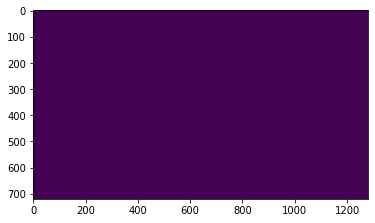

In [29]:
path = "/content/drive/My Drive/H.264 implementation/bunny.mp4"
separation = 5
motion, residuals =compress(path, separation)

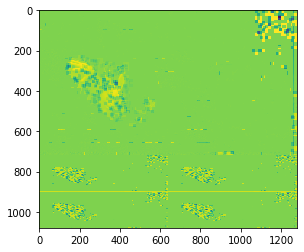

In [33]:
plt.imshow(residuals[4])

In [0]:
def decompress(motion, residuals, path, separation):
  final = generate_frames(motion,residuals,path,separation)
  return final

In [0]:
decompressed_frames = decompress(motion, residuals, path, separation)

In [47]:
len(decompressed_frames)

5

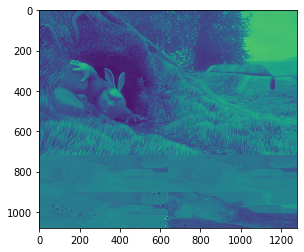

In [49]:
plt.imshow(decompressed_frames[4])